In [494]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import skimage as ski
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt


In [74]:
import warnings
warnings.filterwarnings('ignore')

### Questions : 
1) Certainly, automating the visual inspection of wafers using machine learning techniques is feasible and could yield reliable results.
2) The best results I obtained are : 96,21% accuracy and an F1-Score of 0.72
3) Some strategies that could improve the results are :  


    -Utilizing Data Augmentation: Instead of resampling, augmenting the dataset through techniques like rotation, or adding noise to the images could potentially diversify the dataset. However, due to the binary nature of pixel values (bits), the efficacy of traditional data augmentation might be limited. Binary pixels (0 or 1) restrict the augmentation potential as these transformations could inadvertently alter or distort crucial information, hindering the expected benefits of traditional augmentation methods, especially in preserving meaningful features within the images.

    -Leveraging Ensemble Methods: Employing ensemble methods, especially with a deep learning model as the foundational base, presents a promising avenue to enhance the F1 score (~0.8) and accuracy (~99%). Ensemble methods amalgamate predictions from multiple models, each capturing unique aspects of the data, leading to more robust and accurate predictions. This technique has the potential to significantly improve the overall performance, especially in an extremely imbalanced dataset like the one provided.

    -Hyperparameter Tuning using GridSearchCV or RandomizedSearchCV: Employing these techniques for hyperparameter optimization is pivotal in fine-tuning the deep learning model. By systematically exploring the hyperparameter space, it aims to discover the most optimal configuration, potentially elevating the accuracy to ~98% while concurrently enhancing the F1Score to ~0.8. This systematic search for the best hyperparameters can profoundly impact the model's performance by optimizing its learning process and allowing it to better capture intricate patterns present in the dataset.

    -Exploring Deep Learning models more : particularly the utilization of Convolutional Neural Networks (CNNs), holds the promise of yielding improved outcomes. It's imperative to delve deeper into the suitable CNN architectures through extensive experimentation. 

### Loading The Dataset

We load the data set using read_pickle

In [395]:

df = pd.read_pickle("./waferImg26x26.pkl")
images = df.images.values
labels = df.labels.values
labels = np.asarray([str(l[0]) for l in labels])
labels = pd.DataFrame(labels, columns=['label'])

We can see that there is one feature in the dataset which is just an array of pixels of size (3,26,26), thus for classical classifiers it would be better to have the pixels as features : 

In [396]:
X = np.array(df['images'].tolist())  # Convert image arrays to a numpy array
num_samples, channels, height, width = X.shape
X = X.reshape(num_samples, channels * height * width)
X = pd.DataFrame(X)
X

,0,1,2,3,4,5,6,7,8,9,...,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14361,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14362,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14363,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14364,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We split the dataset into training and testing datasets : 

In [397]:
X_train, X_test, labels_train, labels_test = train_test_split(X, labels, test_size = 0.25)

In [398]:
labels_train.value_counts()

label    
none         10140
Loc            223
Edge-Loc       203
Center          68
Random          59
Scratch         51
Edge-Ring       18
Near-full       11
Donut            1
Name: count, dtype: int64

In [399]:
labels_test.value_counts()

label    
none         3349
Edge-Loc       93
Loc            74
Center         22
Scratch        21
Random         15
Edge-Ring      13
Near-full       5
Name: count, dtype: int64

We apply a simple RandomForestClassifer to get an idea of the baseline : 

In [405]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=1).fit(X_train, labels_train['label'])
y_pred = random_forest.predict(X_test)

In [406]:
print('Accuracy score: ' + str(accuracy_score(labels_test, y_pred)))
print('Recall score: ' + str(recall_score(labels_test, y_pred, average='macro')))
print(classification_report(labels_test, y_pred))

Accuracy score: 0.9490534521158129
Recall score: 0.45296728494132144
              precision    recall  f1-score   support

      Center       0.88      0.32      0.47        22
    Edge-Loc       0.91      0.22      0.35        93
   Edge-Ring       1.00      0.54      0.70        13
         Loc       1.00      0.16      0.28        74
   Near-full       1.00      0.60      0.75         5
      Random       0.82      0.60      0.69        15
     Scratch       1.00      0.19      0.32        21
        none       0.95      1.00      0.97      3349

    accuracy                           0.95      3592
   macro avg       0.94      0.45      0.57      3592
weighted avg       0.95      0.95      0.93      3592



The accuracy is high, which is expected in classification problems with imbalanced datasets, however the f1 score is low, and our goal in this assignment is to improve it using different techniques, like splitting with stratification, oversampling, using hyperparameter tuning ...

### Using Stratify after Duplicating Donut

There is only one sample of the Donut Class, we will try to augment this particular class by rotating the image 3 times, and use `train_test_split` with the stratify parameter to keep the proportion of each class the same in the train and test dataset.  

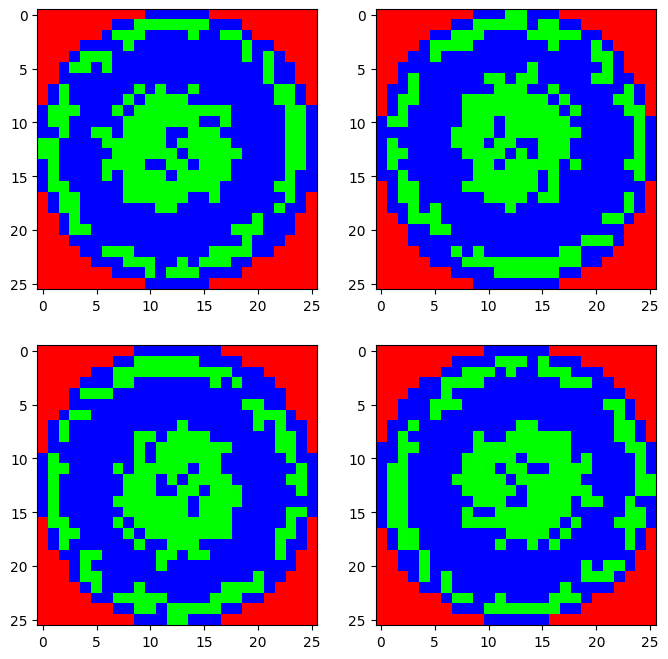

In [434]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

donut_img = X[labels['label']=='Donut']
axs[0, 0].imshow(np.transpose(donut_img.to_numpy().reshape(3,26,26), axes=[1,2,0]))
axs[0, 1].imshow(ski.transform.rotate(np.transpose(donut_img.to_numpy().reshape(3,26,26), axes=[1,2,0]), angle=-90))
axs[1, 0].imshow(ski.transform.rotate(np.transpose(donut_img.to_numpy().reshape(3,26,26), axes=[1,2,0]), angle=90))
axs[1, 1].imshow(ski.transform.rotate(np.transpose(donut_img.to_numpy().reshape(3,26,26), axes=[1,2,0]), angle=180))

In [447]:
# Here we need to make sure to reshape to re-transpose the axes, and reshape the images, to create dataframes that we concatenate with our dataset
donut_1 = donut_img
donut_2 = pd.DataFrame(np.transpose(ski.transform.rotate(np.transpose(donut_img.to_numpy().reshape(3,26,26), axes=[1,2,0]), angle=-90), axes=[2,0,1]).reshape(1,-1))
donut_3 = pd.DataFrame(np.transpose(ski.transform.rotate(np.transpose(donut_img.to_numpy().reshape(3,26,26), axes=[1,2,0]), angle=90), axes=[2,0,1]).reshape(1,-1))
donut_4 = pd.DataFrame(np.transpose(ski.transform.rotate(np.transpose(donut_img.to_numpy().reshape(3,26,26), axes=[1,2,0]), angle=180), axes=[2,0,1]).reshape(1,-1))

concat = pd.concat([donut_1, donut_2, donut_3, donut_4], ignore_index=True)
concat

,0,1,2,3,4,5,6,7,8,9,...,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.262177e-29,3.552714e-15,3.552714e-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0


At first we have 14366 examples, we will add 3 duplicates of the Donuts class so we can have some in the Training, and Test set 

In [452]:
X = pd.concat([X, concat], ignore_index=True)
X

,0,1,2,3,4,5,6,7,8,9,...,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14365,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14366,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14367,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14368,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


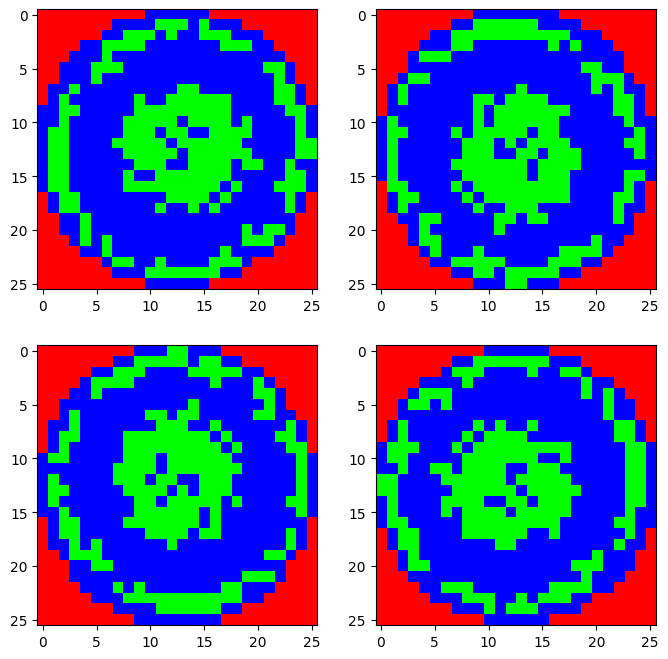

In [457]:
# Make sure everything works fine
# The last Four elements are the Donuts with the different rotations
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
for i, ax in enumerate(axs.flat):
    ax.imshow(np.transpose(X.to_numpy().reshape(-1,3,26,26)[-(i+1)], axes=[1,2,0]))


In [458]:
donut_label = labels[labels['label']=='Donut']
donut_label


,label
10686,Donut


In [459]:
labels = pd.concat([labels]+[donut_label.reset_index(drop=True) for _ in range(4)], ignore_index=True)
labels

,label
0,none
1,none
2,none
3,none
4,none
...,...
14365,none
14366,Donut
14367,Donut
14368,Donut


In [460]:
X[labels['label']=='Donut']

,0,1,2,3,4,5,6,7,8,9,...,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027
10686,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14366,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14367,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14368,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14369,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.262177e-29,3.552714e-15,3.552714e-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [461]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.25, stratify=labels)

In [462]:
y_train.value_counts()

label    
none         10116
Loc            223
Edge-Loc       222
Center          67
Random          56
Scratch         54
Edge-Ring       23
Near-full       12
Donut            4
Name: count, dtype: int64

In [463]:
y_test.value_counts()

label    
none         3373
Edge-Loc       74
Loc            74
Center         23
Random         18
Scratch        18
Edge-Ring       8
Near-full       4
Donut           1
Name: count, dtype: int64

In [466]:
random_forest = RandomForestClassifier(n_estimators=500, random_state=1).fit(X_train, y_train['label'])
y_pred = random_forest.predict(X_test)

In [489]:
print('Accuracy score: ' + str(accuracy_score(y_test['label'], y_pred)))
print('Recall score: ' + str(recall_score(y_test['label'], y_pred, average='macro')))
print(classification_report(y_test['label'], y_pred))


Accuracy score: 0.9521291399944336
Recall score: 0.6323915166235038
              precision    recall  f1-score   support

      Center       0.67      0.52      0.59        23
       Donut       1.00      1.00      1.00         1
    Edge-Loc       0.82      0.43      0.57        74
   Edge-Ring       0.73      1.00      0.84         8
         Loc       0.62      0.14      0.22        74
   Near-full       1.00      1.00      1.00         4
      Random       1.00      0.39      0.56        18
     Scratch       0.25      0.22      0.24        18
        none       0.96      0.99      0.98      3373

    accuracy                           0.95      3593
   macro avg       0.78      0.63      0.67      3593
weighted avg       0.94      0.95      0.94      3593



Confusion matrix:
 [[3343    0    6   12    0    6    6    0    0]
 [   0    8    0    0    0    0    0    0    0]
 [  39    3   32    0    0    0    0    0    0]
 [  14    0    0    4    0    0    0    0    0]
 [  11    0    0    0    7    0    0    0    0]
 [  11    0    0    0    0   12    0    0    0]
 [  63    0    1    0    0    0   10    0    0]
 [   0    0    0    0    0    0    0    4    0]
 [   0    0    0    0    0    0    0    0    1]]


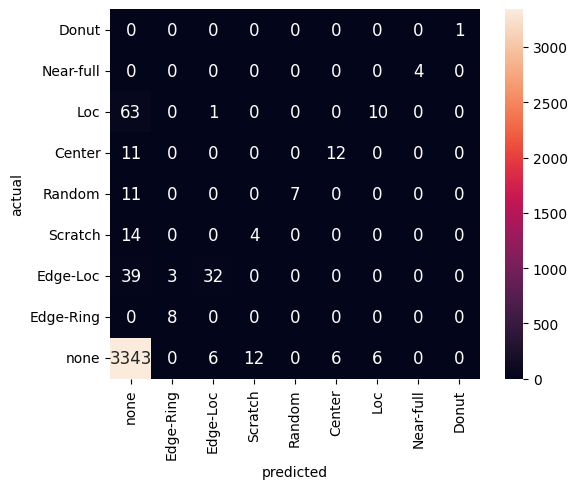

In [496]:
def draw_confusion_matrix(y_true, y_pred, labels) :
    matrix_labels = labels['label'].unique()
    cm = confusion_matrix(y_true, y_pred, labels=matrix_labels)
    print('Confusion matrix:\n', cm)

    df_cm = pd.DataFrame(cm, matrix_labels, matrix_labels)
    ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, square=True, cbar=True, fmt='g')
    plt.xlabel("predicted") 
    plt.ylabel("actual") 
    ax.invert_yaxis()
    plt.show()

draw_confusion_matrix(y_test['label'], y_pred, labels)

Using stratified sampling has notably improved the results, yielding an F1 score of 0.61. While precision is high, indicating fewer false positives, the lower recall suggests a higher occurrence of false negatives. We can see that on the confusion matrix, many shapes that are nont `none` are classified `none` by the model

### Resampling

We will try oversampling the data in this part to see if it is going to improve the performance.  
The `resample` function only resamples one class, we define the make_resample function that resamples all the classes based on the largest represented class (in our case the none class)

In [470]:
def make_resample(_df, column):
    dfs_r = {}
    dfs_c = {}
    bigger = 0
    ignore = ""
    for c in _df[column].unique():
      dfs_c[c] = _df[_df[column] == c]
      if dfs_c[c].shape[0] > bigger:
        bigger = dfs_c[c].shape[0]
        ignore = c
    for c in dfs_c:
      if c == ignore:
        continue
      dfs_r[c] = resample(dfs_c[c], replace=True, n_samples=bigger - dfs_c[c].shape[0], random_state=0)
    return pd.concat([dfs_r[c] for c in dfs_r] + [_df])

In [471]:
concat = pd.concat([X_train,y_train], axis=1)
concat

,0,1,2,3,4,5,6,7,8,9,...,2019,2020,2021,2022,2023,2024,2025,2026,2027,label
12598,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,none
11773,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,none
7989,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,none
12180,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,none
6160,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4956,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,none
12948,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,none
8833,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,none
9087,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,none


In [472]:
oversampled = make_resample(concat,'label')

In [473]:
oversampled['label'].value_counts()

label
Edge-Loc     10116
Loc          10116
Random       10116
Center       10116
Scratch      10116
Edge-Ring    10116
Near-full    10116
Donut        10116
none         10116
Name: count, dtype: int64

In [475]:
random_forest = RandomForestClassifier(n_estimators=90, max_depth=8, random_state=1).fit(oversampled.drop('label', axis=1), oversampled['label'])
y_pred = random_forest.predict(X_test)

In [476]:
print('Accuracy score: ' + str(accuracy_score(y_test['label'], y_pred)))
print('Recall score: ' + str(recall_score(y_test['label'], y_pred, average='macro')))
print(classification_report(y_test['label'], y_pred))

Accuracy score: 0.9521291399944336
Recall score: 0.6323915166235038
              precision    recall  f1-score   support

      Center       0.67      0.52      0.59        23
       Donut       1.00      1.00      1.00         1
    Edge-Loc       0.82      0.43      0.57        74
   Edge-Ring       0.73      1.00      0.84         8
         Loc       0.62      0.14      0.22        74
   Near-full       1.00      1.00      1.00         4
      Random       1.00      0.39      0.56        18
     Scratch       0.25      0.22      0.24        18
        none       0.96      0.99      0.98      3373

    accuracy                           0.95      3593
   macro avg       0.78      0.63      0.67      3593
weighted avg       0.94      0.95      0.94      3593



Confusion matrix:
 [[3343    0    6   12    0    6    6    0    0]
 [   0    8    0    0    0    0    0    0    0]
 [  39    3   32    0    0    0    0    0    0]
 [  14    0    0    4    0    0    0    0    0]
 [  11    0    0    0    7    0    0    0    0]
 [  11    0    0    0    0   12    0    0    0]
 [  63    0    1    0    0    0   10    0    0]
 [   0    0    0    0    0    0    0    4    0]
 [   0    0    0    0    0    0    0    0    1]]


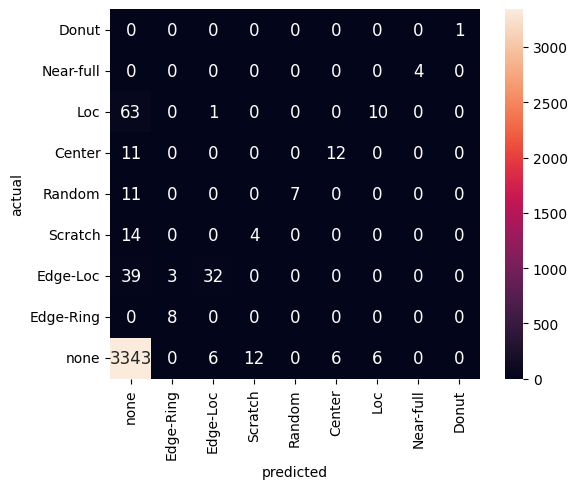

In [497]:
draw_confusion_matrix(y_test['label'], y_pred, labels)

We can see that the oversampled dataset with the given hyperparameters performed a little bit better with an F1 score of 0.67

In [530]:
none_indices = X_train[y_train['label'] == 'none'].index
random_indices = np.random.choice(none_indices, size=(1000,))

X_train_none_subset = X_train.loc[random_indices, :]
y_train_none_subset = y_train.loc[random_indices, :]

X_train_undersampled = pd.concat([X_train[y_train['label']!='none'], X_train_none_subset])
y_train_undersampled = pd.concat([y_train[y_train['label']!='none'], y_train_none_subset])

y_train_undersampled['label'].value_counts()


label
none         1000
Loc           223
Edge-Loc      222
Center         67
Random         56
Scratch        54
Edge-Ring      23
Near-full      12
Donut           4
Name: count, dtype: int64

In [531]:
random_forest = RandomForestClassifier(n_estimators=90, max_depth=8, random_state=1).fit(X_train_undersampled, y_train_undersampled)
y_pred = random_forest.predict(X_test)

In [532]:
print('Accuracy score: ' + str(accuracy_score(y_test['label'], y_pred)))
print('Recall score: ' + str(recall_score(y_test['label'], y_pred, average='macro')))
print(classification_report(y_test['label'], y_pred))

Accuracy score: 0.9515725020873922
Recall score: 0.36688832776369357
              precision    recall  f1-score   support

      Center       1.00      0.17      0.30        23
       Donut       0.00      0.00      0.00         1
    Edge-Loc       0.76      0.30      0.43        74
   Edge-Ring       1.00      0.25      0.40         8
         Loc       0.60      0.08      0.14        74
   Near-full       1.00      1.00      1.00         4
      Random       0.90      0.50      0.64        18
     Scratch       0.00      0.00      0.00        18
        none       0.95      1.00      0.98      3373

    accuracy                           0.95      3593
   macro avg       0.69      0.37      0.43      3593
weighted avg       0.94      0.95      0.94      3593



Confusion matrix:
 [[3372    0    0    0    0    0    1    0    0]
 [   3    2    3    0    0    0    0    0    0]
 [  52    0   22    0    0    0    0    0    0]
 [  18    0    0    0    0    0    0    0    0]
 [   2    0    4    0    9    0    3    0    0]
 [  19    0    0    0    0    4    0    0    0]
 [  68    0    0    0    0    0    6    0    0]
 [   0    0    0    0    0    0    0    4    0]
 [   0    0    0    0    1    0    0    0    0]]


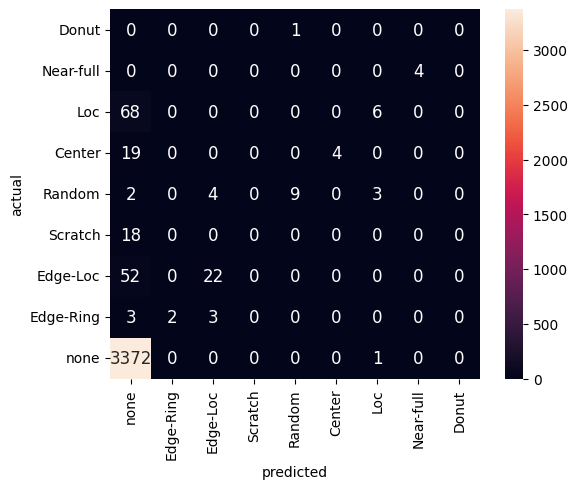

In [533]:
draw_confusion_matrix(y_test['label'], y_pred, labels)

It seems like undersampling performs worse with the chosen parameters.

### Using Xgboost

In [534]:
label_encoder = LabelEncoder()
labels['label_encoded'] = label_encoder.fit_transform(labels['label'])

In [535]:
labels

,label,label_encoded
0,none,8
1,none,8
2,none,8
3,none,8
4,none,8
...,...,...
14365,none,8
14366,Donut,1
14367,Donut,1
14368,Donut,1


In [536]:
X_train, X_test, y_train, y_test = train_test_split(X, labels['label_encoded'], test_size = 0.25, stratify=labels['label_encoded'])

In [537]:
from xgboost import XGBClassifier

In [538]:
model = XGBClassifier(n_estimators=100, max_depth=10,objective='multi:softprob')

In [245]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [246]:
y_pred = model.predict(X_test)
print('Accuracy score: ' + str(accuracy_score(y_test, y_pred)))
print('Recall score: ' + str(recall_score(y_test, y_pred, average='macro')))
print(classification_report(y_test, y_pred))

Accuracy score: 0.960200389646535
Recall score: 0.6148893525879137
              precision    recall  f1-score   support

           0       0.55      0.26      0.35        23
           1       1.00      1.00      1.00         1
           2       0.83      0.47      0.60        74
           3       1.00      0.75      0.86         8
           4       0.86      0.16      0.27        74
           5       1.00      1.00      1.00         4
           6       1.00      0.67      0.80        18
           7       1.00      0.22      0.36        18
           8       0.96      1.00      0.98      3373

    accuracy                           0.96      3593
   macro avg       0.91      0.61      0.69      3593
weighted avg       0.96      0.96      0.95      3593



##### Using GridSearchCV and RandomSearchCV

The performance of the XGBClassifier showcased promising results in our initial evaluation. To further enhance its efficiency and fine-tune the model's performance, our next step involves employing advanced techniques such as RandomizedSearchCV and GridSearchCV. These methods delve deeper into exploring a spectrum of hyperparameters, aiming to optimize the classifier's configuration.

In [81]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV

In [85]:
model = XGBClassifier(objective='multi:softprob')
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3)
space = {'n_estimators': [50, 100, 150, 200], 'max_depth': [5, 10, 15, 20, 25], 'learning_rate': [1, 0.1, 0.01]}
search = RandomizedSearchCV(model, space, n_iter=30, scoring='f1_macro', n_jobs=-1, cv=cv)
result = search.fit(X_train, y_train)

In [91]:
print('Best Hyperparameters: %s' % result.best_params_)

Best Hyperparameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1}


In [88]:
model = XGBClassifier(n_estimators=200, max_depth=10, learninig_rate=0.1 ,objective='multi:softprob')

In [89]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None,
              learninig_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [90]:
y_pred = model.predict(X_test)
print('Accuracy score: ' + str(accuracy_score(y_test, y_pred)))
print('Recall score: ' + str(recall_score(y_test, y_pred, average='macro')))
print(classification_report(y_test, y_pred))

Accuracy score: 0.9576955190648483
Recall score: 0.5751325041296125
              precision    recall  f1-score   support

           0       1.00      0.26      0.41        23
           1       1.00      1.00      1.00         1
           2       0.93      0.35      0.51        74
           3       1.00      0.50      0.67         8
           4       0.72      0.18      0.28        74
           5       1.00      1.00      1.00         4
           6       0.79      0.61      0.69        18
           7       1.00      0.28      0.43        18
           8       0.96      1.00      0.98      3373

    accuracy                           0.96      3593
   macro avg       0.93      0.58      0.66      3593
weighted avg       0.95      0.96      0.95      3593



In [92]:
# we use GridSearch with CrossValidation to evaluate the model
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1,)
space = {'n_estimators': [90, 110, 150, 200, 300], 'max_depth': [5, 10, 15, 20], 'learning_rate': [0.01, 0.1, 1]}
search = GridSearchCV(model, space, scoring='f1', n_jobs=-1, cv=cv)
result = search.fit(X_train, y_train)

In [93]:
print('Best Hyperparameters: %s' % result.best_params_)

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 90}


In [94]:
model = XGBClassifier(n_estimators=90, max_depth=5, learninig_rate=0.01 ,objective='multi:softprob')

In [96]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None,
              learninig_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=90,
              n_jobs=None, num_parallel_tree=None, ...)

In [97]:
y_pred = model.predict(X_test)
print('Accuracy score: ' + str(accuracy_score(y_test, y_pred)))
print('Recall score: ' + str(recall_score(y_test, y_pred, average='macro')))
print(classification_report(y_test, y_pred))

Accuracy score: 0.9582521569718898
Recall score: 0.5781355071326154
              precision    recall  f1-score   support

           0       0.75      0.26      0.39        23
           1       1.00      1.00      1.00         1
           2       0.93      0.35      0.51        74
           3       1.00      0.50      0.67         8
           4       0.83      0.20      0.33        74
           5       1.00      1.00      1.00         4
           6       0.79      0.61      0.69        18
           7       1.00      0.28      0.43        18
           8       0.96      1.00      0.98      3373

    accuracy                           0.96      3593
   macro avg       0.92      0.58      0.67      3593
weighted avg       0.95      0.96      0.95      3593



From our initial trials, it appears that the first set of hyperparameters we employed showcased superior performance compared to our subsequent iterations. However, in order to have better performance we need to run The GridSearchCV on many values, we will leave that for now as it takes a lot of time

We try the same parameters with resampled data

In [539]:
concat = pd.concat([X_train,y_train], axis=1)
oversampled = make_resample(concat, 'label_encoded')

In [540]:
oversampled.label_encoded.value_counts()

label_encoded
0    10116
2    10116
4    10116
7    10116
3    10116
5    10116
6    10116
1    10116
8    10116
Name: count, dtype: int64

In [107]:
model.fit(oversampled.drop('label_encoded', axis=1), oversampled['label_encoded'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None,
              learninig_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=90,
              n_jobs=None, num_parallel_tree=None, ...)

In [108]:
y_pred = model.predict(X_test)
print('Accuracy score: ' + str(accuracy_score(y_test, y_pred)))
print('Recall score: ' + str(recall_score(y_test, y_pred, average='macro')))
print(classification_report(y_test, y_pred))

Accuracy score: 0.9599220706930142
Recall score: 0.5765850436256302
              precision    recall  f1-score   support

           0       1.00      0.30      0.47        23
           1       1.00      1.00      1.00         1
           2       0.88      0.41      0.56        74
           3       1.00      0.62      0.77         8
           4       0.80      0.22      0.34        74
           5       1.00      0.75      0.86         4
           6       0.79      0.61      0.69        18
           7       1.00      0.28      0.43        18
           8       0.96      1.00      0.98      3373

    accuracy                           0.96      3593
   macro avg       0.94      0.58      0.68      3593
weighted avg       0.96      0.96      0.95      3593



### Using AdaBoost

In [67]:
model = AdaBoostClassifier(n_estimators=500, learning_rate=0.1)

In [68]:
result = model.fit(X_train, y_train)

In [75]:
y_pred = model.predict(X_test)
print(set(y_pred))
print(set(y_test))
print('Accuracy score: ' + str(accuracy_score(y_test.to_numpy(), y_pred)))
print('Recall score: ' + str(recall_score(y_test.to_numpy(), y_pred, average='macro')))
print(classification_report(y_test.to_numpy(), y_pred))

{1, 2, 4, 5, 6, 8}
{0, 1, 2, 3, 4, 5, 6, 7, 8}
Accuracy score: 0.49039799610353463
Recall score: 0.4142730782962031
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       1.00      1.00      1.00         1
           2       0.03      0.47      0.06        74
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        74
           5       1.00      0.75      0.86         4
           6       0.03      1.00      0.05        18
           7       0.00      0.00      0.00        18
           8       0.97      0.51      0.66      3373

    accuracy                           0.49      3593
   macro avg       0.34      0.41      0.29      3593
weighted avg       0.91      0.49      0.63      3593



The results of Adaboost are not really promising, XGBClassifer showed better results, thus we won't dwell on this for now.

### Using SVM

In [77]:
from sklearn.svm import SVC

In [78]:
svc=SVC() 

In [79]:
result = svc.fit(X_train, y_train)

In [80]:
y_pred = model.predict(X_test)
print(set(y_pred))
print(set(y_test))
print('Accuracy score: ' + str(accuracy_score(y_test.to_numpy(), y_pred)))
print('Recall score: ' + str(recall_score(y_test.to_numpy(), y_pred, average='macro')))
print(classification_report(y_test.to_numpy(), y_pred))

{1, 2, 4, 5, 6, 8}
{0, 1, 2, 3, 4, 5, 6, 7, 8}
Accuracy score: 0.49039799610353463
Recall score: 0.4142730782962031
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       1.00      1.00      1.00         1
           2       0.03      0.47      0.06        74
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        74
           5       1.00      0.75      0.86         4
           6       0.03      1.00      0.05        18
           7       0.00      0.00      0.00        18
           8       0.97      0.51      0.66      3373

    accuracy                           0.49      3593
   macro avg       0.34      0.41      0.29      3593
weighted avg       0.91      0.49      0.63      3593



Like AdaBoost, the default hyperparameters didn't show promising results, we will keep working with XGBClassifer.

### Using PCA

We plan to employ PCA as an experimental approach despite the intrinsic nature of image data, where pixels have binary values of 0 and 1. The conventional application of Principal Component Analysis (PCA) relies on identifying correlations between features, which in this case, represent individual pixels.   
Initially, it seems counterintuitive to apply PCA in this scenario, as there is a prevailing expectation of minimal correlation between individual pixels. The discrete nature of binary pixels suggests limited variability, which is a primary requirement for PCA's effectiveness. However, despite these reservations, we aim to conduct this experiment to explore any potential insights or unexpected outcomes.

In [164]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [143]:
X_scaled = StandardScaler().fit_transform(X)

In [146]:
cov = (X_scaled.T @ X_scaled) / (X_scaled.shape[0] - 1)

In [148]:
cov.shape

(2028, 2028)

In [149]:
eig_values, eig_vectors = np.linalg.eig(cov)

In [150]:
eig_values.shape

(2028,)

In [151]:
eig_vectors.shape

(2028, 2028)

In [152]:
idx = np.argsort(eig_values, axis=0)[::-1]
sorted_eig_vectors = eig_vectors[:, idx] # sorted in the increasing order of eigen values

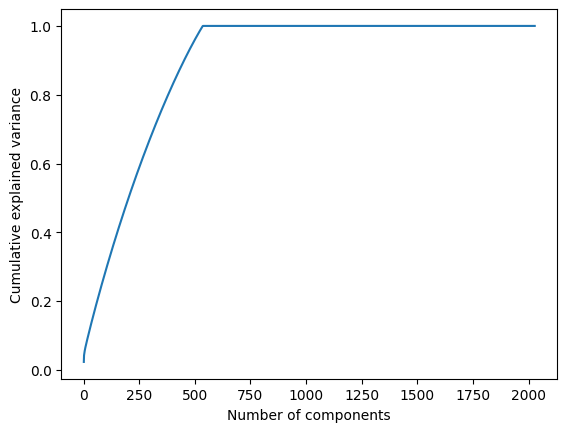

In [158]:
cumsum = np.cumsum(eig_values[idx]) / np.sum(eig_values[idx])
xint = range(1, len(cumsum) + 1)
plt.plot(xint, cumsum)

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

We can see that 500 features are sufficient to explain approximately all the variance, thus we will try to apply PCA with n=500 : 

In [542]:
X_train, X_test, y_train, y_test = train_test_split(X, labels['label_encoded'], test_size = 0.25, stratify=labels['label_encoded'])

In [543]:
pca = PCA(n_components=500)
scaler = StandardScaler()

In [544]:
X_scaled = scaler.fit_transform(X_train)
pca_X_train = pca.fit_transform(X_scaled)

In [545]:
print(sum(pca.explained_variance_ratio_))

0.9575304853760547


In [210]:
model = XGBClassifier(n_estimators=200, max_depth=5, learninig_rate=0.01 ,objective='multi:softprob')

In [211]:
model.fit(pca_X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None,
              learninig_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [212]:
X_test_scaled = scaler.transform(X_test)
pca_X_test = pca.transform(X_test)
y_pred = model.predict(pca_X_test)
print(set(y_pred))
print(set(y_test))
print('Accuracy score: ' + str(accuracy_score(y_test.to_numpy(), y_pred)))
print('Recall score: ' + str(recall_score(y_test.to_numpy(), y_pred, average='macro')))
print(classification_report(y_test.to_numpy(), y_pred))

{8}
{0, 1, 2, 3, 4, 5, 6, 7, 8}
Accuracy score: 0.9387698302254384
Recall score: 0.1111111111111111
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        74
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00        18
           7       0.00      0.00      0.00        18
           8       0.94      1.00      0.97      3373

    accuracy                           0.94      3593
   macro avg       0.10      0.11      0.11      3593
weighted avg       0.88      0.94      0.91      3593



We can see that the PCA didn't really perform well as expected

### Adding Some distance Between bits

In this section, our objective is to assign higher weightage to the bits set to 1, intending to investigate whether this adjustment could potentially yield improved outcomes or performance enhancements.

In [546]:
X_2 = X*2
X_2

,0,1,2,3,4,5,6,7,8,9,...,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027
0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14365,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14366,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14367,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,...,2.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14368,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,...,2.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [547]:
X_train, X_test, y_train, y_test = train_test_split(X_2, labels['label_encoded'], test_size = 0.25, stratify=labels['label_encoded'])

In [548]:
model = XGBClassifier(n_estimators=200, max_depth=5, learninig_rate=0.01 ,objective='multi:softprob', random_state=1)

In [549]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None,
              learninig_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [550]:
y_pred = model.predict(X_test)
print(set(y_pred))
print(set(y_test))
print('Accuracy score: ' + str(accuracy_score(y_test.to_numpy(), y_pred)))
print('Recall score: ' + str(recall_score(y_test.to_numpy(), y_pred, average='macro')))
print(classification_report(y_test.to_numpy(), y_pred))

{0, 1, 2, 3, 4, 5, 6, 7, 8}
{0, 1, 2, 3, 4, 5, 6, 7, 8}
Accuracy score: 0.9557472863902031
Recall score: 0.5661667169087562
              precision    recall  f1-score   support

           0       0.64      0.30      0.41        23
           1       1.00      1.00      1.00         1
           2       0.76      0.30      0.43        74
           3       0.86      0.75      0.80         8
           4       0.70      0.19      0.30        74
           5       1.00      1.00      1.00         4
           6       1.00      0.33      0.50        18
           7       1.00      0.22      0.36        18
           8       0.96      1.00      0.98      3373

    accuracy                           0.96      3593
   macro avg       0.88      0.57      0.64      3593
weighted avg       0.95      0.96      0.94      3593



We tried to multiply with different values other than 2 but we didn't notice any improvement in the results

### Reducing Overfitting

In all the models we worked with before the model seemed to be overfitting the traning data, we will try to reduce overfitting on the XGB classifier.

To reduce Overfitting we can start by reducing the max_depth of the Trees used in XGBClassifier

In [551]:
X_train, X_test, y_train, y_test = train_test_split(X, labels['label_encoded'], test_size = 0.25, stratify=labels['label_encoded'])

In [552]:
model = XGBClassifier(n_estimators=200, max_depth=3, learninig_rate=0.01 ,objective='multi:softprob')

In [553]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None,
              learninig_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [554]:
y_pred = model.predict(X_test)
print(set(y_pred))
print(set(y_test))
print('Accuracy score: ' + str(accuracy_score(y_test.to_numpy(), y_pred)))
print('Recall score: ' + str(recall_score(y_test.to_numpy(), y_pred, average='macro')))
print(classification_report(y_test.to_numpy(), y_pred))

{0, 1, 2, 3, 4, 5, 6, 7, 8}
{0, 1, 2, 3, 4, 5, 6, 7, 8}
Accuracy score: 0.9624269412747009
Recall score: 0.6328638488232795
              precision    recall  f1-score   support

           0       0.92      0.52      0.67        23
           1       1.00      1.00      1.00         1
           2       0.88      0.49      0.63        74
           3       0.86      0.75      0.80         8
           4       0.70      0.22      0.33        74
           5       1.00      1.00      1.00         4
           6       1.00      0.50      0.67        18
           7       1.00      0.22      0.36        18
           8       0.97      1.00      0.98      3373

    accuracy                           0.96      3593
   macro avg       0.92      0.63      0.71      3593
weighted avg       0.96      0.96      0.95      3593



The achieved F1 score of 0.7 is promising, indicating a good performance level. Further hyperparameter tuning has the potential to push this score even higher.

In [555]:
y_pred = model.predict(X_train)
print(set(y_pred))
print(set(y_test))
print('Accuracy score: ' + str(accuracy_score(y_train.to_numpy(), y_pred)))
print('Recall score: ' + str(recall_score(y_train.to_numpy(), y_pred, average='macro')))
print(classification_report(y_train.to_numpy(), y_pred))

{0, 1, 2, 3, 4, 5, 6, 7, 8}
{0, 1, 2, 3, 4, 5, 6, 7, 8}
Accuracy score: 0.9990720979864526
Recall score: 0.9893301070341806
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        67
           1       1.00      1.00      1.00         4
           2       0.99      0.98      0.98       222
           3       1.00      0.96      0.98        23
           4       1.00      1.00      1.00       223
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00        56
           7       1.00      1.00      1.00        54
           8       1.00      1.00      1.00     10116

    accuracy                           1.00     10777
   macro avg       1.00      0.99      0.99     10777
weighted avg       1.00      1.00      1.00     10777



However, the model is still overfitting the training data

We will try to use other hyperparameters like `reg_lambda` used for regularization

In [558]:
model = XGBClassifier(n_estimators=100, max_depth=3, learninig_rate=0.01 ,objective='multi:softprob', reg_lambda=3, min_child_weight=1, gamma=0.2, random_state=1)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None,
              learninig_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [559]:
y_pred = model.predict(X_test)
print(set(y_pred))
print(set(y_test))
print('Accuracy score: ' + str(accuracy_score(y_test.to_numpy(), y_pred)))
print('Recall score: ' + str(recall_score(y_test.to_numpy(), y_pred, average='macro')))
print(classification_report(y_test.to_numpy(), y_pred))

{0, 1, 2, 3, 4, 5, 6, 7, 8}
{0, 1, 2, 3, 4, 5, 6, 7, 8}
Accuracy score: 0.96214862232118
Recall score: 0.6420469449628974
              precision    recall  f1-score   support

           0       0.92      0.48      0.63        23
           1       1.00      1.00      1.00         1
           2       0.90      0.49      0.63        74
           3       0.86      0.75      0.80         8
           4       0.72      0.18      0.28        74
           5       1.00      1.00      1.00         4
           6       1.00      0.67      0.80        18
           7       1.00      0.22      0.36        18
           8       0.96      1.00      0.98      3373

    accuracy                           0.96      3593
   macro avg       0.93      0.64      0.72      3593
weighted avg       0.96      0.96      0.95      3593



We can see a slight improvement of accuracy, and F1 score, we believe that further hyperparameter tuning of `reg_lambda`, `gamma`, and `min_child_weight` will yield better results, by reducing overfitting

In [560]:
y_pred = model.predict(X_train)
print(set(y_pred))
print(set(y_test))
print('Accuracy score: ' + str(accuracy_score(y_train.to_numpy(), y_pred)))
print('Recall score: ' + str(recall_score(y_train.to_numpy(), y_pred, average='macro')))
print(classification_report(y_train.to_numpy(), y_pred))

{0, 1, 2, 3, 4, 5, 6, 7, 8}
{0, 1, 2, 3, 4, 5, 6, 7, 8}
Accuracy score: 0.9922984132875569
Recall score: 0.9402755870715028
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        67
           1       1.00      1.00      1.00         4
           2       1.00      0.89      0.94       222
           3       0.96      1.00      0.98        23
           4       1.00      0.79      0.89       223
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00        56
           7       1.00      0.80      0.89        54
           8       0.99      1.00      1.00     10116

    accuracy                           0.99     10777
   macro avg       0.99      0.94      0.96     10777
weighted avg       0.99      0.99      0.99     10777



### Using Deep Learning

Upon extensively exploring various classical machine learning techniques, we've decided to pivot our approach toward addressing the challenge through the use of deep learning

In [109]:
import tensorflow as tf

In [564]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.5, stratify=labels)

In [565]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, stratify=y_test)

In [566]:
tf_df_train = tf.data.Dataset.from_tensor_slices((X_train,y_train['label_encoded']))
tf_df_val = tf.data.Dataset.from_tensor_slices((X_val,y_val['label_encoded']))

In [567]:
def reshape_to_image(image, label=None) :
    if label is None : 
        return tf.transpose(tf.reshape(image, (3, 26, 26)), perm=[1,2,0])
    return tf.transpose(tf.reshape(image, (3, 26, 26)), perm=[1,2,0]), label

In [568]:
tf_df_train = tf_df_train.map(reshape_to_image)
tf_df_val = tf_df_val.map(reshape_to_image)

tf.Tensor(8, shape=(), dtype=int32)


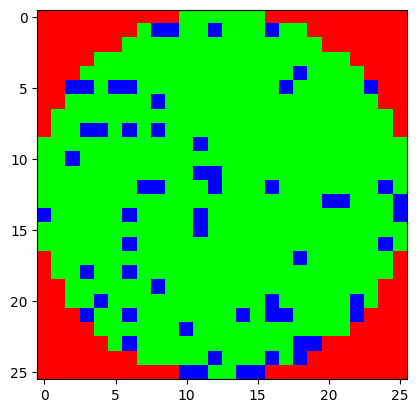

In [569]:
for image, label in tf_df_train.take(1) : 
    print(label)
    plt.imshow(image)  

In [570]:
tf_df_train = tf_df_train.batch(32)
tf_df_val = tf_df_val.batch(32)

In [571]:
result = tf.one_hot(labels['label_encoded'], len(labels['label_encoded'].unique()))
result.shape

TensorShape([14370, 9])

We define our own metrics to compute the f1_macro, precision_macro and recall_macro scores

In [572]:
def macro_f1_score(y_true, y_pred):
    unique_labels = tf.cast(tf.unique(tf.reshape(y_true, [-1])).y, tf.float32)
    num_classes = tf.shape(unique_labels)[0]
    y_true = tf.cast(y_true, tf.float32)
    f1_score = 0.
    
    for i in range(num_classes):
        class_label = unique_labels[i]

        true_positives = tf.keras.backend.sum(
            tf.keras.backend.cast(
                tf.logical_and(tf.equal(y_true, class_label), tf.equal(tf.keras.backend.argmax(y_pred, axis=-1), tf.cast(class_label, tf.int64))), 'float'
            )
        )
        
        possible_positives = tf.keras.backend.sum(tf.cast(tf.equal(y_true, class_label), 'float'))
        predicted_positives = tf.keras.backend.sum(tf.cast(tf.equal(tf.keras.backend.argmax(y_pred, axis=-1), tf.cast(class_label, tf.int64)), 'float'))
        #print(f"i : {i} class_label : {class_label} true_positives : {true_positives} possible_positives : {possible_positives} predicted_positives : {predicted_positives}")
        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
        
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

        f1_score += f1
    
    return f1_score

def macro_precision_score(y_true, y_pred):
    unique_labels = tf.cast(tf.unique(tf.reshape(y_true, [-1])).y, tf.float32)
    num_classes = tf.shape(unique_labels)[0]
    y_true = tf.cast(y_true, tf.float32)
    precision_score = 0.
    
    for i in range(num_classes):
        class_label = unique_labels[i]

        true_positives = tf.keras.backend.sum(
            tf.keras.backend.cast(
                tf.logical_and(tf.equal(y_true, class_label), tf.equal(tf.keras.backend.argmax(y_pred, axis=-1), tf.cast(class_label, tf.int64))), 'float'
            )
        )
        predicted_positives = tf.keras.backend.sum(tf.cast(tf.equal(tf.keras.backend.argmax(y_pred, axis=-1), tf.cast(class_label, tf.int64)), 'float'))
        
        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        
        precision_score += precision
    
    return precision_score

def macro_recall_score(y_true, y_pred):
    unique_labels = tf.cast(tf.unique(tf.reshape(y_true, [-1])).y, tf.float32)
    num_classes = tf.shape(unique_labels)[0]
    y_true = tf.cast(y_true, tf.float32)
    recall_score = 0.
    
    for i in range(num_classes):
        class_label = unique_labels[i]

        true_positives = tf.keras.backend.sum(
            tf.keras.backend.cast(
                tf.logical_and(tf.equal(y_true, class_label), tf.equal(tf.keras.backend.argmax(y_pred, axis=-1), tf.cast(class_label, tf.int64))), 'float'
            )
        )
        
        possible_positives = tf.keras.backend.sum(tf.cast(tf.equal(y_true, class_label), 'float'))
        
        recall = true_positives / (possible_positives + tf.keras.backend.epsilon())

        recall_score += recall
    
    return recall_score

In [573]:
'''Test
y_pred = [[0.4,0.2,1],[9, 20, 34], [34,55,66],[32,75,12],[78,12,14],[13,55,34]]
y_pred_ = [2, 2, 2, 1, 0, 1]
y_true =  [1, 2, 2, 2, 1, 0]
macro_f1_score(y_true, y_pred)
'''

'Test\ny_pred = [[0.4,0.2,1],[9, 20, 34], [34,55,66],[32,75,12],[78,12,14],[13,55,34]]\ny_pred_ = [2, 2, 2, 1, 0, 1]\ny_true =  [1, 2, 2, 2, 1, 0]\nmacro_f1_score(y_true, y_pred)\n'

In [574]:
model_conv = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, 3, padding="same", activation = "relu", input_shape=(26,26,3)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation = "relu",),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation = "relu",),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(9)
])

model_conv.compile(
    optimizer = tf.keras.optimizers.Adam(0.01),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="sca"), 
               tf.keras.metrics.MeanMetricWrapper(macro_f1_score, name='f1'),
               tf.keras.metrics.MeanMetricWrapper(macro_precision_score, name='p'),
               tf.keras.metrics.MeanMetricWrapper(macro_recall_score, name='r')]
)

history = model_conv.fit(
    tf_df_train,
    epochs = 10,
    validation_data = tf_df_val
)

Epoch 1/10
225/225 [==============================] - 3s 7ms/step - loss: 0.3166 - sca: 0.9338 - f1: 30.7659 - p: 30.3556 - r: 31.4222 - val_loss: 0.6332 - val_sca: 0.9401 - val_f1: 30.8531 - val_p: 30.0708 - val_r: 31.7522
Epoch 2/10
225/225 [==============================] - 1s 6ms/step - loss: 0.2218 - sca: 0.9459 - f1: 31.0606 - p: 30.6444 - r: 31.6133 - val_loss: 0.1683 - val_sca: 0.9465 - val_f1: 30.9578 - val_p: 30.4159 - val_r: 31.6195
Epoch 3/10
225/225 [==============================] - 1s 6ms/step - loss: 0.1885 - sca: 0.9492 - f1: 31.0845 - p: 30.6489 - r: 31.6444 - val_loss: 0.1505 - val_sca: 0.9488 - val_f1: 30.9661 - val_p: 30.3451 - val_r: 31.6903
Epoch 4/10
225/225 [==============================] - 1s 6ms/step - loss: 0.1740 - sca: 0.9506 - f1: 31.1359 - p: 30.7378 - r: 31.6533 - val_loss: 0.1467 - val_sca: 0.9507 - val_f1: 30.9979 - val_p: 30.4956 - val_r: 31.6283
Epoch 5/10
225/225 [==============================] - 1s 6ms/step - loss: 0.1507 - sca: 0.9520 - f1: 31.

In [575]:
y_pred = tf.argmax(model_conv.predict(tf.data.Dataset.from_tensor_slices(X_test).map(reshape_to_image).batch(1)), axis=-1)

3593/3593 [==============================] - 5s 1ms/step


In [576]:
print('Accuracy score: ' + str(accuracy_score(y_test['label_encoded'], y_pred)))
print('Recall score: ' + str(recall_score(y_test['label_encoded'], y_pred, average='macro')))
print(classification_report(y_test['label_encoded'], y_pred, zero_division="warn"))

Accuracy score: 0.9576955190648483
Recall score: 0.2505536636745054
              precision    recall  f1-score   support

           0       0.75      0.39      0.51        23
           1       0.00      0.00      0.00         1
           2       0.42      0.51      0.46        74
           3       0.00      0.00      0.00         8
           4       0.81      0.35      0.49        74
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00        19
           7       0.00      0.00      0.00        18
           8       0.97      1.00      0.99      3372

    accuracy                           0.96      3593
   macro avg       0.33      0.25      0.27      3593
weighted avg       0.94      0.96      0.95      3593



In [577]:
model_dense = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(26,26,3)),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(9)
])
model_dense.compile(
    optimizer=tf.keras.optimizers.SGD(0.1),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="sca"), 
               tf.keras.metrics.MeanMetricWrapper(macro_f1_score, name='f1'), 
              ]
)

model_dense.fit(
    tf_df_train,
    epochs=100,
    validation_data=tf_df_val,
)

Epoch 1/100
225/225 [==============================] - 1s 3ms/step - loss: 0.3145 - sca: 0.9363 - f1: 30.8416 - val_loss: 0.2879 - val_sca: 0.9388 - val_f1: 30.7568
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 0.2488 - sca: 0.9411 - f1: 30.9297 - val_loss: 0.2868 - val_sca: 0.9393 - val_f1: 30.7617
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 0.2318 - sca: 0.9436 - f1: 30.9920 - val_loss: 0.2928 - val_sca: 0.9435 - val_f1: 30.8275
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 0.2225 - sca: 0.9459 - f1: 31.0208 - val_loss: 0.2949 - val_sca: 0.9443 - val_f1: 30.8640
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 0.2112 - sca: 0.9463 - f1: 31.0150 - val_loss: 0.2975 - val_sca: 0.9440 - val_f1: 30.8470
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 0.2083 - sca: 0.9481 - f1: 31.0625 - val_loss: 0.2837 - val_sca: 0.9449 - val_f1: 30.8623
Epoch 7/10

In [578]:
y_pred = tf.argmax(model_dense.predict(tf.data.Dataset.from_tensor_slices(X_test).map(reshape_to_image).batch(1)), axis=-1)

3593/3593 [==============================] - 2s 662us/step


In [579]:
print('Accuracy score: ' + str(accuracy_score(y_test['label_encoded'], y_pred)))
print('Recall score: ' + str(recall_score(y_test['label_encoded'], y_pred, average='macro')))
print(classification_report(y_test['label_encoded'], y_pred, zero_division="warn"))

Accuracy score: 0.9312552184803785
Recall score: 0.24731478080195884
              precision    recall  f1-score   support

           0       0.57      0.35      0.43        23
           1       0.00      0.00      0.00         1
           2       0.34      0.20      0.25        74
           3       1.00      0.12      0.22         8
           4       0.20      0.26      0.22        74
           5       0.00      0.00      0.00         4
           6       0.67      0.32      0.43        19
           7       0.00      0.00      0.00        18
           8       0.96      0.98      0.97      3372

    accuracy                           0.93      3593
   macro avg       0.42      0.25      0.28      3593
weighted avg       0.92      0.93      0.93      3593



In [580]:
oversampled

,0,1,2,3,4,5,6,7,8,9,...,2019,2020,2021,2022,2023,2024,2025,2026,2027,label_encoded
10059,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
11437,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6312,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6285,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7549,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12753,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
10793,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
1926,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
9824,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8


In [581]:
tf_df_oversampled = tf.data.Dataset.from_tensor_slices((oversampled.drop(['label_encoded'],axis=1),oversampled['label_encoded']))

In [582]:
tf_df_oversampled = tf_df_oversampled.map(reshape_to_image)

In [583]:
tf_df_oversampled = tf_df_oversampled.batch(32)

In [584]:
model_dense = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(26,26,3)),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(9)
])
model_dense.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="sca"), 
               tf.keras.metrics.MeanMetricWrapper(macro_f1_score, name='f1'), 
              ]
)

model_dense.fit(
    tf_df_oversampled,
    epochs=10,
    validation_data=tf_df_val,
)

Epoch 1/10
2846/2846 [==============================] - 4s 1ms/step - loss: 1.4541 - sca: 0.7395 - f1: 23.7343 - val_loss: 0.4508 - val_sca: 0.9388 - val_f1: 30.7677
Epoch 2/10
2846/2846 [==============================] - 4s 1ms/step - loss: 1.2116 - sca: 0.6780 - f1: 21.7769 - val_loss: 0.4279 - val_sca: 0.9388 - val_f1: 30.7677
Epoch 3/10
2846/2846 [==============================] - 3s 1ms/step - loss: 1.2130 - sca: 0.6769 - f1: 21.7431 - val_loss: 0.4270 - val_sca: 0.9388 - val_f1: 30.7677
Epoch 4/10
2846/2846 [==============================] - 3s 1ms/step - loss: 1.2128 - sca: 0.6769 - f1: 21.7431 - val_loss: 0.4270 - val_sca: 0.9388 - val_f1: 30.7677
Epoch 5/10
2846/2846 [==============================] - 3s 1ms/step - loss: 1.2127 - sca: 0.6769 - f1: 21.7431 - val_loss: 0.4270 - val_sca: 0.9388 - val_f1: 30.7677
Epoch 6/10
2846/2846 [==============================] - 3s 1ms/step - loss: 1.2127 - sca: 0.6769 - f1: 21.7431 - val_loss: 0.4270 - val_sca: 0.9388 - val_f1: 30.7677
Epoc

Our journey into Deep Learning did not produce notably superior results in contrast to classical Machine Learning classifiers. Nonetheless, with additional experimentation and dedicated time, we anticipate identifying the appropriate architecture and hyperparameters necessary to potentially elevate the performance of Deep Learning models.